### Importuri:

In [52]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, ProgressCallback
from datasets import Dataset 
import torch
from datetime import datetime
import json
import re
from sklearn.utils.multiclass import unique_labels

### Setari si directoare:


In [39]:
DATA_PATH = "big-data/discharge-notes"
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
TARGET_COLUMN = "discharge_disposition"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = f"models/alexc/pubmedbert_{timestamp}"
LOG_DIR = f"logs/pubmedbert_{timestamp}"
MAX_LEN = 512
NUM_ROWS = 5000  # initial subset
EPOCHS = 3

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

* Pentru o prima antrenare, am folosit 5000 de randuri si 3 epoci. 
* Rezultatele obtinute au fost:
{'eval_loss': 0.8811196088790894, 'eval_accuracy': 0.655982905982906, 'eval_f1': 0.6272515589823282, 'eval_runtime': 16.0849, 'eval_samples_per_second': 29.096, 'eval_steps_per_second': 3.668, 'epoch': 2.0}

### Citirea subsetului de date:

In [ ]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv")).head(NUM_ROWS)
val_df = pd.read_csv(os.path.join(DATA_PATH, "val.csv")).head(NUM_ROWS//10)
test_df = pd.read_csv(os.path.join(DATA_PATH, "test.csv")).head(NUM_ROWS//10)

### Preprocesare text:
* Combinam coloanele text intr-un singur text
* Aplicam curatarea si combinarea pe toate seturile
* Cream mapping intre label-uri si indexuri
* Mapam label-urile in coloana numerica 'label'
* Salvam mapping-ul labelurilor intr-un fisier JSON
* Cream dataset-uri HuggingFace din Pandas
* Eliminam randurile cu label None

In [ ]:
TEXT_COLUMNS = [
    'chief_complaint', 'major_surgical_procedure', 'history_of_present_illness',
    'past_medical_history', 'family_history', 'physical_exam', 'pertinent_results',
    'cxr', 'us', 'brief_hospital_course', 'medications_on_admission',
    'discharge_medications', 'discharge_condition', 'discharge_instructions'
]

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9.,;:()\- ]', '', text)
    return text.strip()

def combine_text(row):
    return " ".join([clean_text(row[col]) for col in TEXT_COLUMNS if pd.notnull(row[col])])

for df in [train_df, val_df, test_df]:
    df['text'] = df.apply(combine_text, axis=1)

In [ ]:
labels = train_df[TARGET_COLUMN].dropna().unique().tolist()
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

for df in [train_df, val_df, test_df]:
    df.dropna(subset=[TARGET_COLUMN], inplace=True)
    df['label'] = df[TARGET_COLUMN].map(label2id)

with open(os.path.join(OUTPUT_DIR, "label_mappings.json"), "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, indent=4)

In [58]:
train_dataset = Dataset.from_pandas(train_df[['text','label']], preserve_index=False)
val_dataset   = Dataset.from_pandas(val_df[['text','label']], preserve_index=False)
test_dataset  = Dataset.from_pandas(test_df[['text','label']], preserve_index=False)

train_dataset = train_dataset.filter(lambda x: x['label'] is not None)
val_dataset   = val_dataset.filter(lambda x: x['label'] is not None)
test_dataset  = test_dataset.filter(lambda x: x['label'] is not None)

Filter:   0%|          | 0/4750 [00:00<?, ? examples/s]

Filter:   0%|          | 0/470 [00:00<?, ? examples/s]

Filter:   0%|          | 0/470 [00:00<?, ? examples/s]

### Tokenizarea textului:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=MAX_LEN)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])
val_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])
test_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])

Map:   0%|          | 0/4750 [00:00<?, ? examples/s]

Map:   0%|          | 0/470 [00:00<?, ? examples/s]

Map:   0%|          | 0/468 [00:00<?, ? examples/s]

### Incarcare model PubMedBERT pentru clasificare multi-clasa

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Functie pentru calculul metricilor folosind sklearn

In [ ]:
def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}

### Argumentele pentru trainer:

In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir=LOG_DIR,
    logging_strategy="steps",
    do_eval=True,
    logging_steps=20,
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2, 
    learning_rate=5e-5,
)

### Cream Trainer:

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[ProgressCallback()]
)

### Antrenarea modelului:

In [ ]:
trainer.train()

  0%|          | 0/1782 [00:00<?, ?it/s]

/Users/alexcostan/DigitalTriage/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
20,1.721600
40,1.386500
60,1.286200
80,1.248000
100,1.245100
120,1.371900
140,1.249900
160,1.122400
180,1.175700
200,1.153700


{'loss': 1.7216, 'grad_norm': 4.016005039215088, 'learning_rate': 4.9466891133557805e-05, 'epoch': 0.03}
{'loss': 1.3865, 'grad_norm': 22.840425491333008, 'learning_rate': 4.890572390572391e-05, 'epoch': 0.07}
{'loss': 1.2862, 'grad_norm': 4.72327995300293, 'learning_rate': 4.834455667789001e-05, 'epoch': 0.1}
{'loss': 1.248, 'grad_norm': 3.5052998065948486, 'learning_rate': 4.778338945005612e-05, 'epoch': 0.13}
{'loss': 1.2451, 'grad_norm': 6.77862024307251, 'learning_rate': 4.722222222222222e-05, 'epoch': 0.17}
{'loss': 1.3719, 'grad_norm': 8.31851577758789, 'learning_rate': 4.666105499438833e-05, 'epoch': 0.2}
{'loss': 1.2499, 'grad_norm': 4.808602333068848, 'learning_rate': 4.6099887766554436e-05, 'epoch': 0.24}
{'loss': 1.1224, 'grad_norm': 9.225107192993164, 'learning_rate': 4.5538720538720543e-05, 'epoch': 0.27}
{'loss': 1.1757, 'grad_norm': 14.440418243408203, 'learning_rate': 4.4977553310886644e-05, 'epoch': 0.3}
{'loss': 1.1537, 'grad_norm': 6.627777099609375, 'learning_rate'

/Users/alexcostan/DigitalTriage/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 0.8559, 'grad_norm': 6.085801601409912, 'learning_rate': 3.319304152637486e-05, 'epoch': 1.01}
{'loss': 0.7836, 'grad_norm': 13.617205619812012, 'learning_rate': 3.263187429854097e-05, 'epoch': 1.04}
{'loss': 0.8733, 'grad_norm': 4.7709574699401855, 'learning_rate': 3.2070707070707075e-05, 'epoch': 1.08}
{'loss': 0.8793, 'grad_norm': 11.00998306274414, 'learning_rate': 3.1509539842873176e-05, 'epoch': 1.11}
{'loss': 0.9102, 'grad_norm': 8.898727416992188, 'learning_rate': 3.094837261503928e-05, 'epoch': 1.14}
{'loss': 0.8703, 'grad_norm': 8.268499374389648, 'learning_rate': 3.0387205387205387e-05, 'epoch': 1.18}
{'loss': 0.8435, 'grad_norm': 16.935453414916992, 'learning_rate': 2.9826038159371495e-05, 'epoch': 1.21}
{'loss': 0.9634, 'grad_norm': 8.324589729309082, 'learning_rate': 2.9264870931537595e-05, 'epoch': 1.25}
{'loss': 1.0831, 'grad_norm': 32.068172454833984, 'learning_rate': 2.8703703703703706e-05, 'epoch': 1.28}
{'loss': 0.7665, 'grad_norm': 14.493302345275879, 'lea

/Users/alexcostan/DigitalTriage/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 0.7967, 'grad_norm': 7.471226692199707, 'learning_rate': 1.6358024691358026e-05, 'epoch': 2.02}
{'loss': 0.7499, 'grad_norm': 6.956912994384766, 'learning_rate': 1.579685746352413e-05, 'epoch': 2.05}
{'loss': 0.786, 'grad_norm': 6.815985202789307, 'learning_rate': 1.5235690235690236e-05, 'epoch': 2.09}
{'loss': 0.5736, 'grad_norm': 4.738465309143066, 'learning_rate': 1.4674523007856342e-05, 'epoch': 2.12}
{'loss': 0.5861, 'grad_norm': 20.53875160217285, 'learning_rate': 1.4113355780022448e-05, 'epoch': 2.15}
{'loss': 0.6694, 'grad_norm': 10.385696411132812, 'learning_rate': 1.3552188552188552e-05, 'epoch': 2.19}
{'loss': 0.5938, 'grad_norm': 22.32697105407715, 'learning_rate': 1.2991021324354657e-05, 'epoch': 2.22}
{'loss': 0.697, 'grad_norm': 5.353165626525879, 'learning_rate': 1.2429854096520765e-05, 'epoch': 2.26}
{'loss': 0.5857, 'grad_norm': 20.2606258392334, 'learning_rate': 1.1868686868686869e-05, 'epoch': 2.29}
{'loss': 0.5358, 'grad_norm': 18.919540405273438, 'learnin

TrainOutput(global_step=1782, training_loss=0.8708173078720016, metrics={'train_runtime': 1663.8245, 'train_samples_per_second': 8.565, 'train_steps_per_second': 1.071, 'total_flos': 3749837495040000.0, 'train_loss': 0.8708173078720016, 'epoch': 3.0})

### Predict pe setul de test + Raport de clasificare pentru clasele prezente

In [ ]:
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
labels_present = unique_labels(y_true, y_pred)

print(classification_report(
    y_true,
    y_pred,
    labels=labels_present,
    target_names=[id2label[i] for i in labels_present]
))

/Users/alexcostan/DigitalTriage/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/59 [00:00<?, ?it/s]

                               precision    recall  f1-score   support

      Extended Care Facility:       0.76      0.61      0.68        95
                         Home       0.75      0.86      0.80       235
  Home With Service Facility:       0.49      0.44      0.46       118
                      Expired       0.53      0.67      0.59        12
            Home with Service       0.00      0.00      0.00         2
                Extended Care       0.00      0.00      0.00         4
            Expired Facility:       0.00      0.00      0.00         1
Home With Service Facility: .       0.00      0.00      0.00         1

                     accuracy                           0.68       468
                    macro avg       0.32      0.32      0.32       468
                 weighted avg       0.67      0.68      0.67       468



/Users/alexcostan/DigitalTriage/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/alexcostan/DigitalTriage/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/alexcostan/DigitalTriage/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

### Evaluare finala pe setul de test:
* salvare rezultate de evaluare intr-un fisier

In [ ]:
results = trainer.evaluate(test_dataset)
print(results)
with open(os.path.join(OUTPUT_DIR, "eval_results.json"), "w") as f:
    json.dump(results, f, indent=4)

/Users/alexcostan/DigitalTriage/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.9152539968490601, 'eval_accuracy': 0.6837606837606838, 'eval_f1': 0.6711490978157645, 'eval_precision': 0.6667961735199534, 'eval_recall': 0.6837606837606838, 'eval_runtime': 15.8405, 'eval_samples_per_second': 29.545, 'eval_steps_per_second': 3.725, 'epoch': 3.0}


### Salvarea modelului final:

In [ ]:
trainer.save_model(OUTPUT_DIR)

### Confusion Matrix:

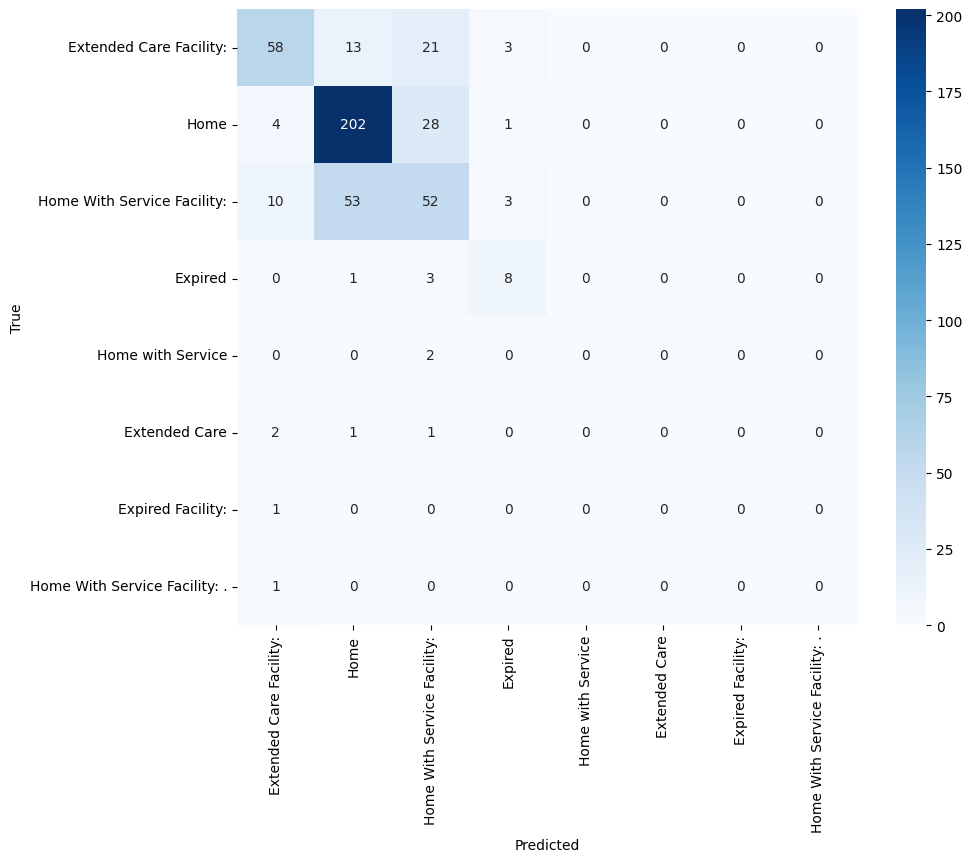

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=labels_present)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=[id2label[i] for i in labels_present],
            yticklabels=[id2label[i] for i in labels_present], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()